In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale
from scipy.ndimage import rotate

import chromatix.functional as cf
from jax import Array, vmap, pmap, jit, value_and_grad
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

%config InlineBackend.figure_format='retina'

In [3]:
# Getting phantom
image = shepp_logan_phantom().astype(np.float16)
image = rescale(image, scale=0.64, mode='reflect', channel_axis=None)
print(image.shape)

(256, 256)


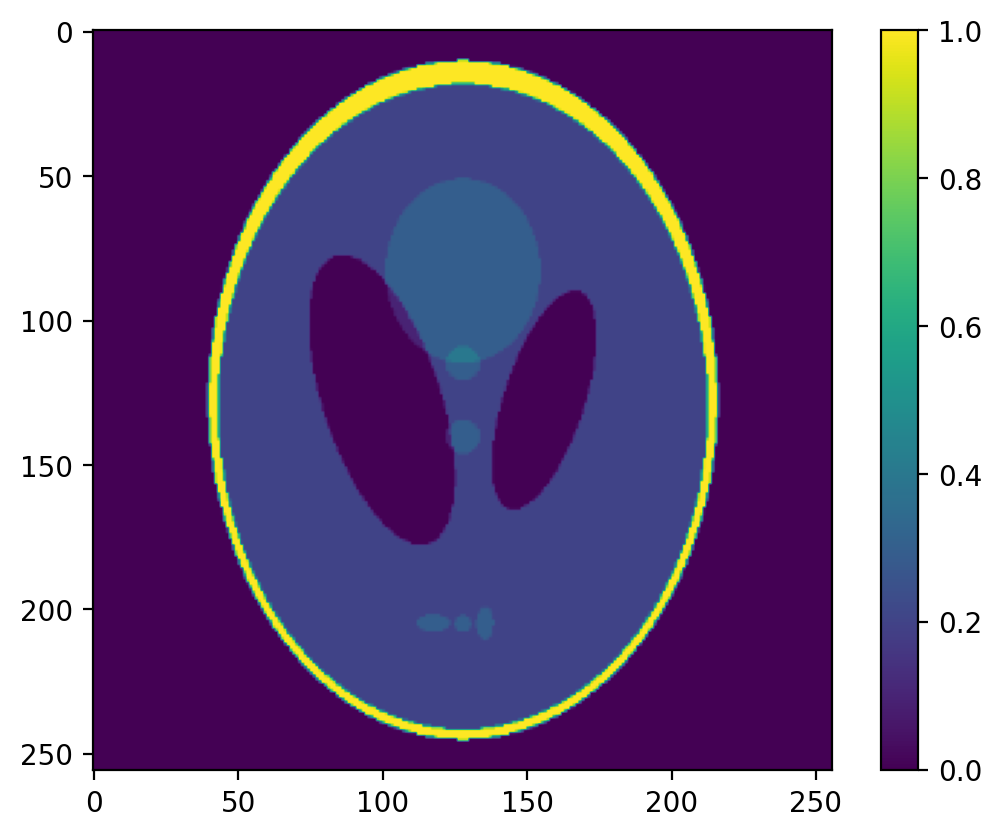

In [4]:
plt.imshow(image)
plt.colorbar()

In [5]:
image.max()

1.0

In [6]:
# Make few rotations
angles = np.linspace(0, 360, 15)

# We need to use linear interpolation, otherwise the values change too much. 
baseline = np.stack([rotate(image, angle, reshape=False, order=1) for angle in angles]) 
print(image.max(), baseline.max())

1.0 1.0


In [7]:
# Adding in fake y axis - just repeated
dataset = np.repeat(np.expand_dims(baseline, 1), 256, axis=1)
dataset = np.moveaxis(dataset, -1, 1)
print(f"Dataset shape [angle, z, y, x]: {dataset.shape}")

Dataset shape [angle, z, y, x]: (15, 256, 256, 256)


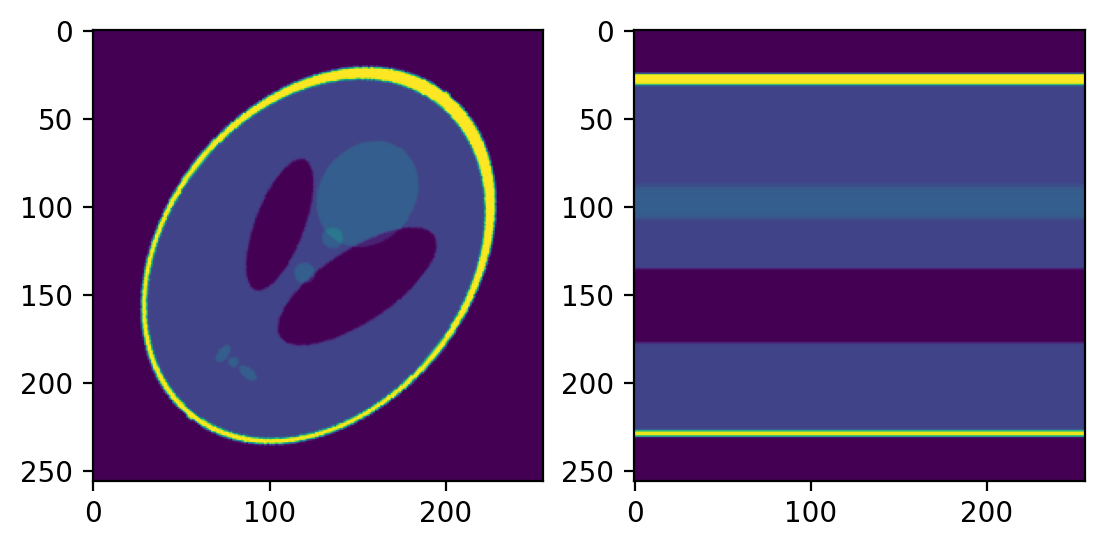

In [8]:
plt.subplot(121)
plt.imshow(dataset[5, :, 128, :])

plt.subplot(122)
plt.imshow(dataset[5, :, :, 128])

In [41]:
def diff_rotate(volume, angle):
    Nx, Ny, Nz = volume.shape
    # Making grid
    grid = jnp.mgrid[-Nx // 2 : Nx // 2, -Ny // 2 : Ny // 2, -Nz // 2 : Nz // 2] + 1/2
    grid = jnp.transpose(grid, (1, 2, 3, 0))
    # adding homogeneous coordinates
    grid = jnp.concatenate([grid, jnp.ones((*grid.shape[:3], 1))], axis=-1)
    
    # making affine matrix
    M = jnp.eye(4)
    M = M @ Ryz(angle)
    
    # Deforming grid and resampling
    deformed_grid = (grid @ M.transpose())[..., :3]
    return resample(volume, deformed_grid)

def resample(vol: Array, grid: Array) -> jnp.ndarray:
    # assume original coordinates were centered, i.e. -N/2 -> N/2
    offset = jnp.array(vol.shape)[:, None] // 2 - 1/2
    resampled = map_coordinates(vol, grid.reshape(-1, 3).T + offset, order=1, mode='constant', cval=0.0)
    return resampled.reshape(grid.shape[:3])

def Ryz(theta: float) -> jnp.ndarray:
    """Roll rotations."""
    R = jnp.zeros((4, 4))

    sin_t = jnp.sin(theta)
    cos_t = jnp.cos(theta)

    R = R.at[1, 1].set(1.0)
    R = R.at[3, 3].set(1.0)  # homogeneous
    R = R.at[0, 0].set(cos_t)
    R = R.at[2, 2].set(cos_t)
    R = R.at[0, 2].set(sin_t)
    R = R.at[2, 0].set(-sin_t)

    return R

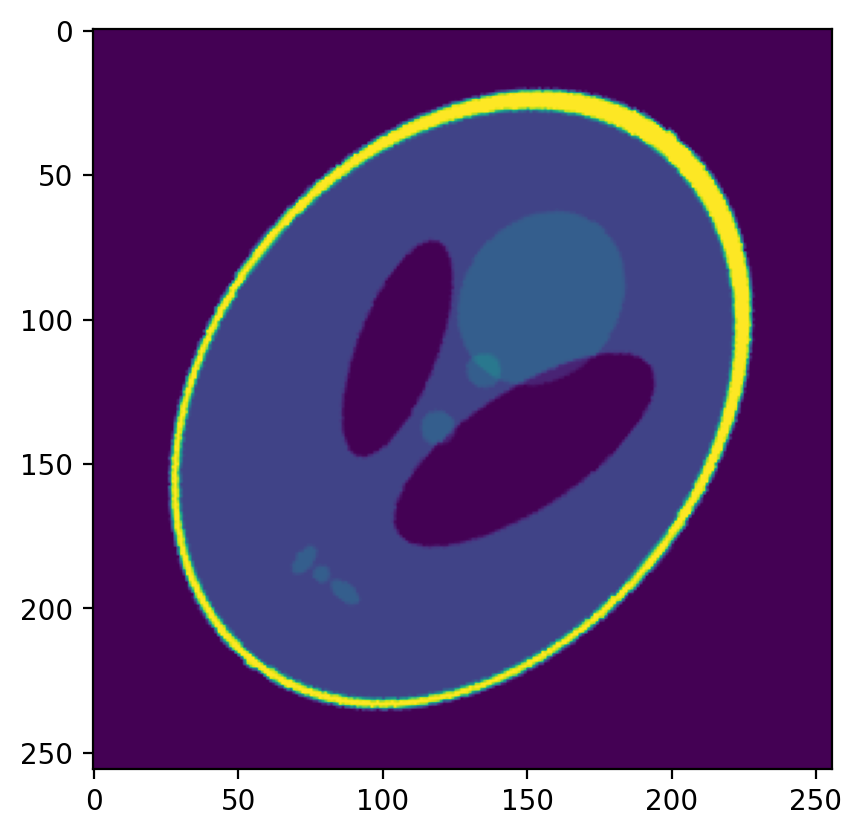

In [31]:
plt.imshow(diff_rotate(dataset[0], -angles[5] / 180 * np.pi)[:, 128, :])

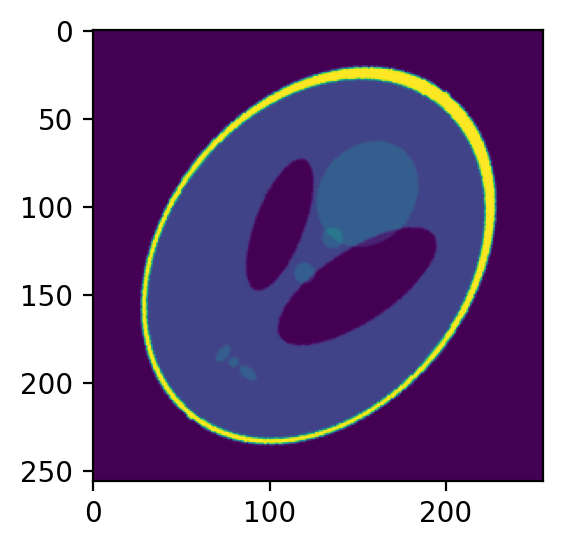

In [32]:
plt.subplot(121)
plt.imshow(dataset[5, :, 128, :])

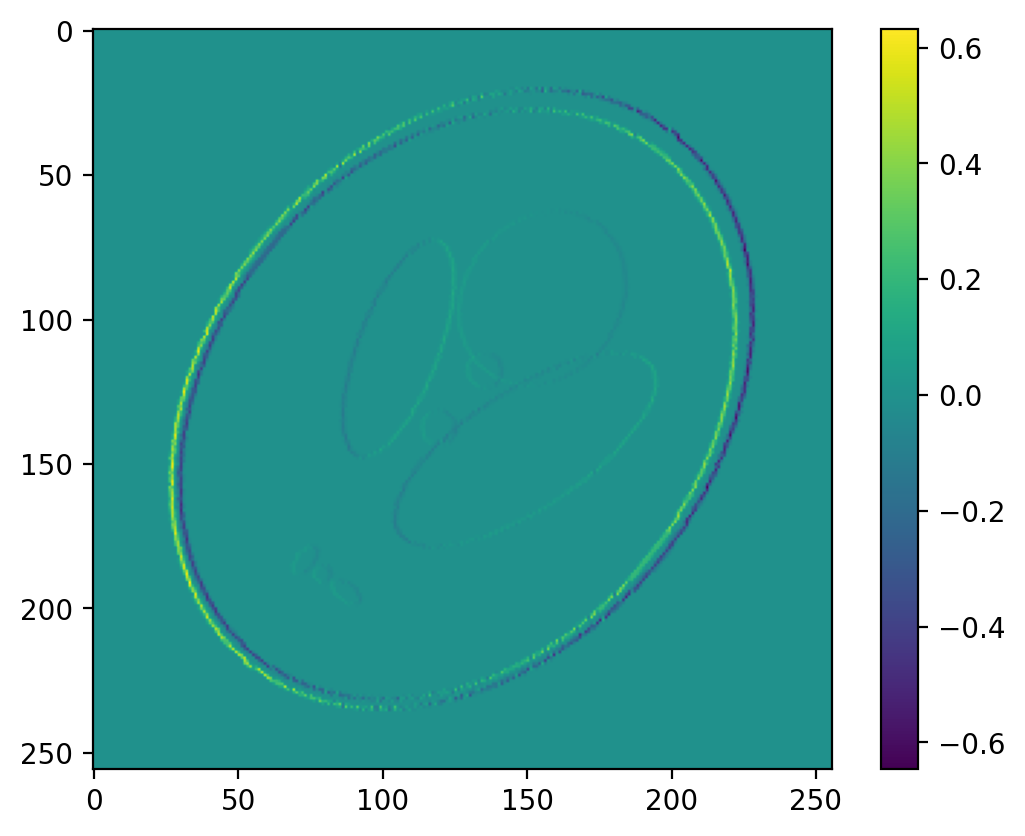

In [33]:
plt.imshow(diff_rotate(dataset[0], -angles[5] / 180 * np.pi)[:, 128, :] - dataset[5, :, 128, :])
plt.colorbar()

In [34]:
plt.plot(np.arange(256), [150, 128, :], 'x-')
plt.plot(np.arange(256), dataset[5, 150, 128, :], 'x-')

SyntaxError: invalid syntax (333279000.py, line 1)

In [42]:
new = np.stack([diff_rotate(dataset[0], -angle / 180 * np.pi) for angle in angles])

In [43]:
new.shape

(15, 256, 256, 256)

In [44]:
dataset.shape

(15, 256, 256, 256)

In [45]:
np.mean((new - dataset)**2, axis=(1, 2, 3))

array([0.0000000e+00, 2.4805071e-13, 2.5671658e-13, 2.6057384e-13,
       2.4880751e-13, 2.5224441e-13, 3.5798139e-13, 2.4313068e-13,
       2.4805090e-13, 8.9910029e-13, 3.1864225e-13, 3.9776646e-13,
       9.1950601e-13, 2.5434876e-13, 1.0542710e-12], dtype=float32)

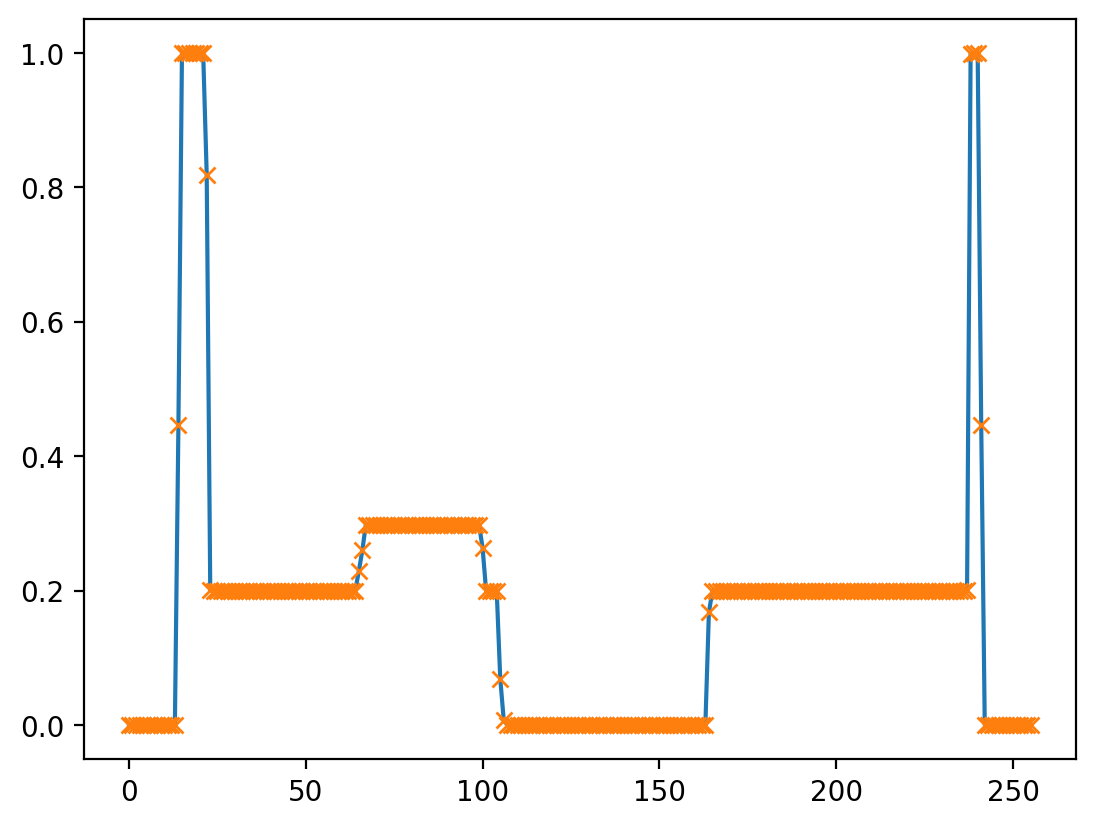

In [46]:
plt.plot(new[0, 150, 128])
plt.plot(dataset[0, 150, 128], 'x')

In [27]:
baseline.shape

(15, 256, 256)